In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
from typing import Any, Dict, List
import datetime
from pathlib import Path

## Data Acquisition and Loading

National Vulnerability Database (NVD)

In [ ]:
# NVD Data Loading
def process_nvd_json(file_path: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Process an NVD JSON file and convert it to two normalized DataFrames:
    1. Main CVE DataFrame
    2. CPE matches DataFrame with foreign key to CVE

    Args:
        file_path (str): Path to the NVD JSON file

    Returns:
        tuple[pd.DataFrame, pd.DataFrame]: Tuple containing (cve_df, cpe_df)
    """
    # Read the JSON file
    with open(file_path, 'r', encoding = 'ISO-8859-1') as f:
        nvd_data = json.load(f)

    # Lists to store processed items
    cve_items = []
    cpe_items = []

    for cve_item in nvd_data['CVE_Items']:
        cve_data = {}

        # Basic CVE information
        cve_id = cve_item['cve']['CVE_data_meta']['ID']
        cve_data['id'] = cve_id
        cve_data['assigner'] = cve_item['cve']['CVE_data_meta']['ASSIGNER']
        cve_data['published_date'] = cve_item['publishedDate']
        cve_data['last_modified_date'] = cve_item['lastModifiedDate']

        # Description
        descriptions = cve_item['cve']['description']['description_data']
        cve_data['description'] = next((desc['value'] for desc in descriptions if desc['lang'] == 'en'), '')

        # Problem type (CWE)
        try:
            problemtype_data = cve_item['cve']['problemtype']['problemtype_data']
            if problemtype_data and problemtype_data[0]['description']:
                cve_data['cwe'] = problemtype_data[0]['description'][0].get('value', '')
            else:
                cve_data['cwe'] = ''
        except (KeyError, IndexError):
            cve_data['cwe'] = ''

        # References
        try:
            references = cve_item['cve']['references']['reference_data']
            cve_data['references'] = '; '.join(ref['url'] for ref in references)
        except (KeyError, IndexError):
            cve_data['references'] = ''

        # CVSS v3 metrics
        try:
            cvss3 = cve_item['impact']['baseMetricV3']['cvssV3']
            cve_data['cvss3_vector'] = cvss3.get('vectorString', '')
            cve_data['cvss3_base_score'] = cvss3.get('baseScore', None)
            cve_data['cvss3_base_severity'] = cvss3.get('baseSeverity', '')
            cve_data['attack_vector'] = cvss3.get('attackVector', '')
            cve_data['attack_complexity'] = cvss3.get('attackComplexity', '')
            cve_data['privileges_required'] = cvss3.get('privilegesRequired', '')
            cve_data['user_interaction'] = cvss3.get('userInteraction', '')
            cve_data['scope'] = cvss3.get('scope', '')
            cve_data['confidentiality_impact'] = cvss3.get('confidentialityImpact', '')
            cve_data['integrity_impact'] = cvss3.get('integrityImpact', '')
            cve_data['availability_impact'] = cvss3.get('availabilityImpact', '')
        except (KeyError, TypeError):
            cve_data.update({
                'cvss3_vector': '',
                'cvss3_base_score': None,
                'cvss3_base_severity': '',
                'attack_vector': '',
                'attack_complexity': '',
                'privileges_required': '',
                'user_interaction': '',
                'scope': '',
                'confidentiality_impact': '',
                'integrity_impact': '',
                'availability_impact': ''
            })

        # Process CPE matches
        try:
            nodes = cve_item['configurations']['nodes']
            for node in nodes:
                if 'cpe_match' in node:
                    for cpe in node['cpe_match']:
                        cpe_info = {
                            'cve_id': cve_id,
                            'cpe23Uri': cpe.get('cpe23Uri', ''),
                            'vulnerable': cpe.get('vulnerable', False),
                            'versionStartIncluding': cpe.get('versionStartIncluding', ''),
                            'versionEndIncluding': cpe.get('versionEndIncluding', ''),
                            'versionStartExcluding': cpe.get('versionStartExcluding', ''),
                            'versionEndExcluding': cpe.get('versionEndExcluding', '')
                        }

                        # Parse CPE URI into components
                        cpe_parts = cpe_info['cpe23Uri'].split(':')
                        if len(cpe_parts) > 4:
                            cpe_info.update({
                                'vendor': cpe_parts[3],
                                'product': cpe_parts[4],
                                'version': cpe_parts[5]
                            })

                        cpe_items.append(cpe_info)
        except (KeyError, TypeError):
            pass

        cve_items.append(cve_data)

    # Create DataFrames
    cve_df = pd.DataFrame(cve_items)
    cpe_df = pd.DataFrame(cpe_items)

    # Convert date columns to datetime
    date_columns = ['published_date', 'last_modified_date']
    for col in date_columns:
        cve_df[col] = pd.to_datetime(cve_df[col])

    # Sort DataFrames
    cve_df = cve_df.sort_values('id')
    cpe_df = cpe_df.sort_values(['cve_id', 'cpe23Uri'])
    return cve_df, cpe_df


# Replace with your file name and path
file_path_2023 = "/content/drive/MyDrive/BIT3474GroupProject/data/nvdcve-1.1-2023.json"
file_path_2022 = "/content/drive/MyDrive/BIT3474GroupProject/data/nvdcve-1.1-2022.json"
file_path_2024 = "/content/drive/MyDrive/BIT3474GroupProject/data/nvdcve-1.1-2024.json"

try:
    # Process the NVD JSON file
    cve_df_2023, cpe_df_2023 = process_nvd_json(file_path_2023)
    cve_df_2022, cpe_df_2022 = process_nvd_json(file_path_2022)
    cve_df_2024, cpe_df_2024 = process_nvd_json(file_path_2024)

    # Optionally save to CSV
    cve_df_2023.to_csv('processed_cve_data.csv', index=False)
    cpe_df_2023.to_csv('processed_cpe_data.csv', index=False)
    cve_df_2022.to_csv('processed_cve_data.csv', index=False)
    cpe_df_2022.to_csv('processed_cpe_data.csv', index=False)
    cve_df_2024.to_csv('processed_cve_data.csv', index=False)
    cpe_df_2024.to_csv('processed_cpe_data.csv', index=False)

except FileNotFoundError:
    print(f"Error: File '{file_path_2023}' not found.")
    print(f"Error: File '{file_path_2022}' not found.")
    print(f"Error: File '{file_path_2024}' not found.")
except json.JSONDecodeError:
    print("Error: Invalid JSON file format.")
except Exception as e:
    print(f"Error processing file: {str(e)}")

In [ ]:
# Concatenating all three NVD DataFrames into one DataFrame
nvd_df = pd.concat([cve_df_2024, cve_df_2023, cve_df_2022], axis=0, ignore_index=True)

In [ ]:
# The accumulated first attempt of the NVD DataFrame
nvd_df

,id,assigner,published_date,last_modified_date,description,cwe,references,cvss3_vector,cvss3_base_score,cvss3_base_severity,attack_vector,attack_complexity,privileges_required,user_interaction,scope,confidentiality_impact,integrity_impact,availability_impact
0,CVE-2024-0001,psirt@purestorage.com,2024-09-23 18:15:00+00:00,2024-09-27 14:08:00+00:00,A condition exists in FlashArray Purity whereb...,CWE-1188,https://purestorage.com/security,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,9.8,CRITICAL,NETWORK,LOW,NONE,NONE,UNCHANGED,HIGH,HIGH,HIGH
1,CVE-2024-0002,psirt@purestorage.com,2024-09-23 18:15:00+00:00,2024-09-27 14:13:00+00:00,A condition exists in FlashArray Purity whereb...,NVD-CWE-noinfo,https://purestorage.com/security,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,9.8,CRITICAL,NETWORK,LOW,NONE,NONE,UNCHANGED,HIGH,HIGH,HIGH
2,CVE-2024-0003,psirt@purestorage.com,2024-09-23 18:15:00+00:00,2024-09-27 14:23:00+00:00,A condition exists in FlashArray Purity whereb...,NVD-CWE-noinfo,https://purestorage.com/security,CVSS:3.1/AV:N/AC:L/PR:H/UI:N/S:U/C:H/I:H/A:H,7.2,HIGH,NETWORK,LOW,HIGH,NONE,UNCHANGED,HIGH,HIGH,HIGH
3,CVE-2024-0004,psirt@purestorage.com,2024-09-23 18:15:00+00:00,2024-09-27 14:24:00+00:00,A condition exists in FlashArray Purity whereb...,CWE-94,https://purestorage.com/security,CVSS:3.1/AV:N/AC:L/PR:H/UI:N/S:U/C:H/I:H/A:H,7.2,HIGH,NETWORK,LOW,HIGH,NONE,UNCHANGED,HIGH,HIGH,HIGH
4,CVE-2024-0005,psirt@purestorage.com,2024-09-23 18:15:00+00:00,2024-09-27 15:25:00+00:00,A condition exists in FlashArray and FlashBlad...,CWE-77,https://purestorage.com/security,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,8.8,HIGH,NETWORK,LOW,LOW,NONE,UNCHANGED,HIGH,HIGH,HIGH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93517,CVE-2022-49929,cve@kernel.org,2025-05-01 15:16:00+00:00,2025-05-01 15:16:00+00:00,"In the Linux kernel, the following vulnerabili...",,https://git.kernel.org/stable/c/50b35ad2864a9d...,,NaN,,,,,,,,,
93518,CVE-2022-49930,cve@kernel.org,2025-05-01 15:16:00+00:00,2025-05-07 13:28:00+00:00,"In the Linux kernel, the following vulnerabili...",CWE-476,https://git.kernel.org/stable/c/0e23e85d86b78e...,CVSS:3.1/AV:L/AC:L/PR:L/UI:N/S:U/C:N/I:N/A:H,5.5,MEDIUM,LOCAL,LOW,LOW,NONE,UNCHANGED,NONE,NONE,HIGH
93519,CVE-2022-49931,cve@kernel.org,2025-05-01 15:16:00+00:00,2025-05-07 13:29:00+00:00,"In the Linux kernel, the following vulnerabili...",CWE-476,https://git.kernel.org/stable/c/1afac08b39d854...,CVSS:3.1/AV:L/AC:L/PR:L/UI:N/S:U/C:N/I:N/A:H,5.5,MEDIUM,LOCAL,LOW,LOW,NONE,UNCHANGED,NONE,NONE,HIGH
93520,CVE-2022-49932,cve@kernel.org,2025-05-02 16:15:00+00:00,2025-05-02 16:15:00+00:00,"In the Linux kernel, the following vulnerabili...",,https://git.kernel.org/stable/c/e136e969d268b9...,,NaN,,,,,,,,,


In [ ]:
# Choosing the preferred NVD columns to be stored for the final merged dataframe
nvd_selected_columns = ['id', 'published_date', 'last_modified_date', 'description', 'cwe', 'cvss3_base_score', 'cvss3_base_severity']
nvd_df = nvd_df[nvd_selected_columns]

In [ ]:
# Renaming each of the preferred columns to be readable for anyone
nvd_df.rename(columns={'id': 'CVE ID', 'published_date': 'Published Date', 'last_modified_date': 'Last Modified Date', 'description': 'Description', 'cwe': 'CWE ID', 'cvss3_base_score': 'CVSS3 Base Score', 'cvss3_base_sevirity': 'CVSS3 Base Sevirity'}, inplace=True)

<ipython-input-7-ca5634e1bb49>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nvd_df.rename(columns={'id': 'CVE ID', 'published_date': 'Published Date', 'last_modified_date': 'Last Modified Date', 'description': 'Description', 'cwe': 'CWE ID', 'cvss3_base_score': 'CVSS3 Base Score', 'cvss3_base_sevirity': 'CVSS3 Base Sevirity'}, inplace=True)


In [ ]:
# The final NVD DataFrame
nvd_df

,CVE ID,Published Date,Last Modified Date,Description,CWE ID,CVSS3 Base Score,cvss3_base_severity
0,CVE-2024-0001,2024-09-23 18:15:00+00:00,2024-09-27 14:08:00+00:00,A condition exists in FlashArray Purity whereb...,CWE-1188,9.8,CRITICAL
1,CVE-2024-0002,2024-09-23 18:15:00+00:00,2024-09-27 14:13:00+00:00,A condition exists in FlashArray Purity whereb...,NVD-CWE-noinfo,9.8,CRITICAL
2,CVE-2024-0003,2024-09-23 18:15:00+00:00,2024-09-27 14:23:00+00:00,A condition exists in FlashArray Purity whereb...,NVD-CWE-noinfo,7.2,HIGH
3,CVE-2024-0004,2024-09-23 18:15:00+00:00,2024-09-27 14:24:00+00:00,A condition exists in FlashArray Purity whereb...,CWE-94,7.2,HIGH
4,CVE-2024-0005,2024-09-23 18:15:00+00:00,2024-09-27 15:25:00+00:00,A condition exists in FlashArray and FlashBlad...,CWE-77,8.8,HIGH
...,...,...,...,...,...,...,...
93517,CVE-2022-49929,2025-05-01 15:16:00+00:00,2025-05-01 15:16:00+00:00,"In the Linux kernel, the following vulnerabili...",,NaN,
93518,CVE-2022-49930,2025-05-01 15:16:00+00:00,2025-05-07 13:28:00+00:00,"In the Linux kernel, the following vulnerabili...",CWE-476,5.5,MEDIUM
93519,CVE-2022-49931,2025-05-01 15:16:00+00:00,2025-05-07 13:29:00+00:00,"In the Linux kernel, the following vulnerabili...",CWE-476,5.5,MEDIUM
93520,CVE-2022-49932,2025-05-02 16:15:00+00:00,2025-05-02 16:15:00+00:00,"In the Linux kernel, the following vulnerabili...",,NaN,


Known Exploited Vulnerabilities (KEV)

In [ ]:
# KEV Data Loading
kev_file_path = 'https://www.cisa.gov/sites/default/files/feeds/known_exploited_vulnerabilities.json'
kev_request = requests.get(kev_file_path)
kev_read = kev_request.json()
kev_df = pd.DataFrame(kev_read['vulnerabilities'])

In [ ]:
# Removing any unnecessary columns for the last dataframe
kev_df = kev_df.drop(['knownRansomwareCampaignUse', 'dueDate'], axis=1)

In [ ]:
# Renaming the columns to be more accessible
kev_df.rename(columns={'cveID': 'CVE ID', 'vendorProject': 'Vendor Projected', 'product': 'Product', 'vulnerabilityName': 'Vulnerability Name', 'dateAdded': 'Date Added', 'shortDescription': 'Short Description', 'requiredAction': 'Required Action', 'dueDate': 'Due Date', 'notes': 'Notes', 'cwes': 'CWES ID'}, inplace=True)

In [ ]:
# Converting the date columns to datetime
kev_date_columns = ['Date Added']
for col in kev_date_columns:
    kev_df[col] = pd.to_datetime(kev_df[col])

# Sorting the KEV DataFrame
kev_df = kev_df.sort_values('CVE ID')
kev_df = kev_df.reset_index(drop=True)

In [ ]:
# The final KEV DataFrame
kev_df

,CVE ID,Vendor Projected,Product,Vulnerability Name,Date Added,Short Description,Required Action,Notes,CWES ID
0,CVE-2002-0367,Microsoft,Windows,Microsoft Windows Privilege Escalation Vulnera...,2022-03-03,smss.exe debugging subsystem in Microsoft Wind...,Apply updates per vendor instructions.,https://nvd.nist.gov/vuln/detail/CVE-2002-0367,[]
1,CVE-2004-0210,Microsoft,Windows,Microsoft Windows Privilege Escalation Vulnera...,2022-03-03,A privilege elevation vulnerability exists in ...,Apply updates per vendor instructions.,https://nvd.nist.gov/vuln/detail/CVE-2004-0210,[CWE-120]
2,CVE-2004-1464,Cisco,IOS,Cisco IOS Denial-of-Service Vulnerability,2023-05-19,Cisco IOS contains an unspecified vulnerabilit...,Apply updates per vendor instructions.,https://sec.cloudapps.cisco.com/security/cente...,[]
3,CVE-2005-2773,Hewlett Packard (HP),OpenView Network Node Manager,HP OpenView Network Node Manager Remote Code E...,2022-03-25,HP OpenView Network Node Manager could allow a...,Apply updates per vendor instructions.,https://nvd.nist.gov/vuln/detail/CVE-2005-2773,[]
4,CVE-2006-1547,Apache,Struts 1,Apache Struts 1 ActionForm Denial-of-Service V...,2022-01-21,ActionForm in Apache Struts versions before 1....,Apply updates per vendor instructions.,https://nvd.nist.gov/vuln/detail/CVE-2006-1547,[]
...,...,...,...,...,...,...,...,...,...
1330,CVE-2025-31324,SAP,NetWeaver,SAP NetWeaver Unrestricted File Upload Vulnera...,2025-04-29,SAP NetWeaver Visual Composer Metadata Uploade...,"Apply mitigations per vendor instructions, fol...",https://me.sap.com/notes/3594142 ; https://nvd...,[CWE-434]
1331,CVE-2025-3248,Langflow,Langflow,Langflow Missing Authentication Vulnerability,2025-05-05,Langflow contains a missing authentication vul...,"Apply mitigations per vendor instructions, fol...",This vulnerability affects a common open-sourc...,[CWE-306]
1332,CVE-2025-34028,Commvault,Command Center,Commvault Command Center Path Traversal Vulner...,2025-05-02,Commvault Command Center contains a path trave...,"Apply mitigations per vendor instructions, fol...",https://documentation.commvault.com/securityad...,[CWE-22]
1333,CVE-2025-3928,Commvault,Web Server,Commvault Web Server Unspecified Vulnerability,2025-04-28,Commvault Web Server contains an unspecified v...,"Apply mitigations per vendor instructions, fol...",https://documentation.commvault.com/securityad...,[]


Common Weakness Enumeration (CWE)

In [ ]:
# CWE Data Loading
def comprehensive_field_extractor(data):
    """
    Extract all fields from CWE weakness data, including nested fields stored as separate columns.

    :param data: Raw CWE weakness data
    :return: Flattened dictionary of all extractable fields
    """
    flattened = {}

    # Core weakness fields
    core_fields = [
        'ID', 'Name', 'Abstraction', 'Structure',
        'Status', 'Description', 'ExtendedDescription', 'LikelihoodOfExploit', 'BackgroundDetails'
    ]
    for field in core_fields:
        flattened[field] = data.get(field, 'N/A')

    # Complex nested fields
    # ApplicablePlatforms
    flattened['Platforms'] = ', '.join([
        f"{p.get('Type', '')}: {p.get('Class', '')}"
        for p in data.get('ApplicablePlatforms', [])
    ])

    # CommonConsequences (split into separate columns)
    common_consequences = data.get('CommonConsequences', [])
    for i, consequence in enumerate(common_consequences):
        flattened[f'Consequence_{i+1}_Scope'] = consequence.get('Scope', 'N/A')
        flattened[f'Consequence_{i+1}_Impact'] = consequence.get('Impact', 'N/A')

    # ObservedExamples (split into separate columns)
    observed_examples = data.get('ObservedExamples', [])
    for i, example in enumerate(observed_examples):
        flattened[f'ObservedExample_{i+1}_Reference'] = example.get('Reference', 'N/A')
        flattened[f'ObservedExample_{i+1}_Description'] = example.get('Description', 'N/A')

    # References (split into separate columns)
    references = data.get('References', [])
    for i, reference in enumerate(references):
        flattened[f'Reference_{i+1}_Title'] = reference.get('Title', 'N/A')
        flattened[f'Reference_{i+1}_URL'] = reference.get('URL', 'N/A')  # Add more fields if needed

    return flattened

cwe_file_path = 'https://cwe-api.mitre.org/api/v1/cwe/weakness/all'
cwe_response = requests.get(cwe_file_path)

# If the file path was successful, then the raw JSON data will be extracted and
# used in the function comprehensive_field_extractor
if cwe_response.status_code == 200:
    cwe_raw_data = cwe_response.json()  # Extract JSON data
else:
    print(f"Error: Failed to retrieve CWE data (Status Code: {cwe_response.status_code})")
    exit()

data = cwe_response.json()

flattened_weaknesses = [
        comprehensive_field_extractor(weakness)
        for weakness in data.get("Weaknesses", [])
    ]


# Creating the CWE DataFrame from the CWE column "Weaknesses"
cwe_df = pd.DataFrame(cwe_raw_data.get("Weaknesses"))
csv_filename = "cwe_data.csv"
cwe_df.to_csv(csv_filename, index=False)

In [ ]:
# Selecting the required CWE columns within "Weaknesses"
select_cwe_columns = ['ID', 'Name', 'Description', 'TaxonomyMappings']
cwe_df = cwe_df[select_cwe_columns]
cwe_df = cwe_df.rename(columns={'ID': 'CWE ID', 'Name': 'CWE Name', 'Description': 'CWE Description', 'TaxonomyMappings': 'Taxonomy Mappings'})

In [ ]:
# The first attempt of the CWE DataFrame
cwe_df

,CWE ID,CWE Name,CWE Description,Taxonomy Mappings
0,1004,Sensitive Cookie Without 'HttpOnly' Flag,The product uses a cookie to store sensitive i...,NaN
1,1007,Insufficient Visual Distinction of Homoglyphs ...,The product displays information or identifier...,NaN
2,102,Struts: Duplicate Validation Forms,The product uses multiple validation forms wit...,"[{'TaxonomyName': '7 Pernicious Kingdoms', 'En..."
3,1021,Improper Restriction of Rendered UI Layers or ...,The web application does not restrict or incor...,NaN
4,1022,Use of Web Link to Untrusted Target with windo...,The web application produces links to untruste...,NaN
...,...,...,...,...
963,95,Improper Neutralization of Directives in Dynam...,The product receives input from an upstream co...,"[{'TaxonomyName': 'PLOVER', 'EntryName': 'Dire..."
964,96,Improper Neutralization of Directives in Stati...,The product receives input from an upstream co...,"[{'TaxonomyName': 'PLOVER', 'EntryName': 'Dire..."
965,97,Improper Neutralization of Server-Side Include...,"The product generates a web page, but does not...","[{'TaxonomyName': 'PLOVER', 'EntryName': 'Serv..."
966,98,Improper Control of Filename for Include/Requi...,The PHP application receives input from an ups...,"[{'TaxonomyName': 'PLOVER', 'EntryName': 'PHP ..."


In [ ]:
# After noticing the CWE ID column only had numbers, we decided to add "CWE-"
# to each number to clarify and identify where the numbers came from
cwe_df['CWE ID'] = cwe_df['CWE ID'].apply(lambda x: 'CWE-' + str(x))
cwe_df

,CWE ID,CWE Name,CWE Description,Taxonomy Mappings
0,CWE-1004,Sensitive Cookie Without 'HttpOnly' Flag,The product uses a cookie to store sensitive i...,NaN
1,CWE-1007,Insufficient Visual Distinction of Homoglyphs ...,The product displays information or identifier...,NaN
2,CWE-102,Struts: Duplicate Validation Forms,The product uses multiple validation forms wit...,"[{'TaxonomyName': '7 Pernicious Kingdoms', 'En..."
3,CWE-1021,Improper Restriction of Rendered UI Layers or ...,The web application does not restrict or incor...,NaN
4,CWE-1022,Use of Web Link to Untrusted Target with windo...,The web application produces links to untruste...,NaN
...,...,...,...,...
963,CWE-95,Improper Neutralization of Directives in Dynam...,The product receives input from an upstream co...,"[{'TaxonomyName': 'PLOVER', 'EntryName': 'Dire..."
964,CWE-96,Improper Neutralization of Directives in Stati...,The product receives input from an upstream co...,"[{'TaxonomyName': 'PLOVER', 'EntryName': 'Dire..."
965,CWE-97,Improper Neutralization of Server-Side Include...,"The product generates a web page, but does not...","[{'TaxonomyName': 'PLOVER', 'EntryName': 'Serv..."
966,CWE-98,Improper Control of Filename for Include/Requi...,The PHP application receives input from an ups...,"[{'TaxonomyName': 'PLOVER', 'EntryName': 'PHP ..."


## Data Cleaning and Transformation



In [ ]:
# The first merge dataframe was between the NVD DataFrame and the
# KEV Catalog DataFrame
merged_df = pd.merge(nvd_df, kev_df, on='CVE ID', how='left')
merged_df

,CVE ID,Published Date,Last Modified Date,Description,CWE ID,CVSS3 Base Score,cvss3_base_severity,Vendor Projected,Product,Vulnerability Name,Date Added,Short Description,Required Action,Notes,CWES ID
0,CVE-2024-0001,2024-09-23 18:15:00+00:00,2024-09-27 14:08:00+00:00,A condition exists in FlashArray Purity whereb...,CWE-1188,9.8,CRITICAL,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
1,CVE-2024-0002,2024-09-23 18:15:00+00:00,2024-09-27 14:13:00+00:00,A condition exists in FlashArray Purity whereb...,NVD-CWE-noinfo,9.8,CRITICAL,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
2,CVE-2024-0003,2024-09-23 18:15:00+00:00,2024-09-27 14:23:00+00:00,A condition exists in FlashArray Purity whereb...,NVD-CWE-noinfo,7.2,HIGH,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
3,CVE-2024-0004,2024-09-23 18:15:00+00:00,2024-09-27 14:24:00+00:00,A condition exists in FlashArray Purity whereb...,CWE-94,7.2,HIGH,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
4,CVE-2024-0005,2024-09-23 18:15:00+00:00,2024-09-27 15:25:00+00:00,A condition exists in FlashArray and FlashBlad...,CWE-77,8.8,HIGH,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93517,CVE-2022-49929,2025-05-01 15:16:00+00:00,2025-05-01 15:16:00+00:00,"In the Linux kernel, the following vulnerabili...",,NaN,,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
93518,CVE-2022-49930,2025-05-01 15:16:00+00:00,2025-05-07 13:28:00+00:00,"In the Linux kernel, the following vulnerabili...",CWE-476,5.5,MEDIUM,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
93519,CVE-2022-49931,2025-05-01 15:16:00+00:00,2025-05-07 13:29:00+00:00,"In the Linux kernel, the following vulnerabili...",CWE-476,5.5,MEDIUM,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
93520,CVE-2022-49932,2025-05-02 16:15:00+00:00,2025-05-02 16:15:00+00:00,"In the Linux kernel, the following vulnerabili...",,NaN,,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN


In [ ]:
# The last part of the merge was including the CWE DataFrame as well
merged_df = pd.merge(merged_df, cwe_df, on='CWE ID', how='left')

In [ ]:
# The final merged dataframe from all three stored dataframes
merged_df

,CVE ID,Published Date,Last Modified Date,Description,CWE ID,CVSS3 Base Score,cvss3_base_severity,Vendor Projected,Product,Vulnerability Name,Date Added,Short Description,Required Action,Notes,CWES ID,CWE Name,CWE Description,Taxonomy Mappings
0,CVE-2024-0001,2024-09-23 18:15:00+00:00,2024-09-27 14:08:00+00:00,A condition exists in FlashArray Purity whereb...,CWE-1188,9.8,CRITICAL,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,Initialization of a Resource with an Insecure ...,The product initializes or sets a resource wit...,NaN
1,CVE-2024-0002,2024-09-23 18:15:00+00:00,2024-09-27 14:13:00+00:00,A condition exists in FlashArray Purity whereb...,NVD-CWE-noinfo,9.8,CRITICAL,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CVE-2024-0003,2024-09-23 18:15:00+00:00,2024-09-27 14:23:00+00:00,A condition exists in FlashArray Purity whereb...,NVD-CWE-noinfo,7.2,HIGH,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CVE-2024-0004,2024-09-23 18:15:00+00:00,2024-09-27 14:24:00+00:00,A condition exists in FlashArray Purity whereb...,CWE-94,7.2,HIGH,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,Improper Control of Generation of Code ('Code ...,The product constructs all or part of a code s...,"[{'TaxonomyName': 'PLOVER', 'EntryID': 'CODE',..."
4,CVE-2024-0005,2024-09-23 18:15:00+00:00,2024-09-27 15:25:00+00:00,A condition exists in FlashArray and FlashBlad...,CWE-77,8.8,HIGH,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,Improper Neutralization of Special Elements us...,The product constructs all or part of a comman...,"[{'TaxonomyName': '7 Pernicious Kingdoms', 'En..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93517,CVE-2022-49929,2025-05-01 15:16:00+00:00,2025-05-01 15:16:00+00:00,"In the Linux kernel, the following vulnerabili...",,NaN,,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93518,CVE-2022-49930,2025-05-01 15:16:00+00:00,2025-05-07 13:28:00+00:00,"In the Linux kernel, the following vulnerabili...",CWE-476,5.5,MEDIUM,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NULL Pointer Dereference,The product dereferences a pointer that it exp...,"[{'TaxonomyName': '7 Pernicious Kingdoms', 'En..."
93519,CVE-2022-49931,2025-05-01 15:16:00+00:00,2025-05-07 13:29:00+00:00,"In the Linux kernel, the following vulnerabili...",CWE-476,5.5,MEDIUM,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NULL Pointer Dereference,The product dereferences a pointer that it exp...,"[{'TaxonomyName': '7 Pernicious Kingdoms', 'En..."
93520,CVE-2022-49932,2025-05-02 16:15:00+00:00,2025-05-02 16:15:00+00:00,"In the Linux kernel, the following vulnerabili...",,NaN,,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Calculating the vulnerability age (time elapsed since
# vulnerability disclosure)

# Make the Published Date column in datetime format and timezone-naive
merged_df['Published Date'] = pd.to_datetime(merged_df['Published Date']).dt.tz_localize(None)

# Calculate the vulnerability age
merged_df['Vulnerability Age'] = (pd.Timestamp.now().tz_localize(None) - merged_df['Published Date']).dt.days

merged_df['is_exploited'] = merged_df['Date Added'].notnull()

merged_df

,CVE ID,Published Date,Last Modified Date,Description,CWE ID,CVSS3 Base Score,cvss3_base_severity,Vendor Projected,Product,Vulnerability Name,Date Added,Short Description,Required Action,Notes,CWES ID,CWE Name,CWE Description,Taxonomy Mappings,Vulnerability Age,is_exploited
0,CVE-2024-0001,2024-09-23 18:15:00,2024-09-27 14:08:00+00:00,A condition exists in FlashArray Purity whereb...,CWE-1188,9.8,CRITICAL,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,Initialization of a Resource with an Insecure ...,The product initializes or sets a resource wit...,NaN,227,False
1,CVE-2024-0002,2024-09-23 18:15:00,2024-09-27 14:13:00+00:00,A condition exists in FlashArray Purity whereb...,NVD-CWE-noinfo,9.8,CRITICAL,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,227,False
2,CVE-2024-0003,2024-09-23 18:15:00,2024-09-27 14:23:00+00:00,A condition exists in FlashArray Purity whereb...,NVD-CWE-noinfo,7.2,HIGH,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,227,False
3,CVE-2024-0004,2024-09-23 18:15:00,2024-09-27 14:24:00+00:00,A condition exists in FlashArray Purity whereb...,CWE-94,7.2,HIGH,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,Improper Control of Generation of Code ('Code ...,The product constructs all or part of a code s...,"[{'TaxonomyName': 'PLOVER', 'EntryID': 'CODE',...",227,False
4,CVE-2024-0005,2024-09-23 18:15:00,2024-09-27 15:25:00+00:00,A condition exists in FlashArray and FlashBlad...,CWE-77,8.8,HIGH,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,Improper Neutralization of Special Elements us...,The product constructs all or part of a comman...,"[{'TaxonomyName': '7 Pernicious Kingdoms', 'En...",227,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93517,CVE-2022-49929,2025-05-01 15:16:00,2025-05-01 15:16:00+00:00,"In the Linux kernel, the following vulnerabili...",,NaN,,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,False
93518,CVE-2022-49930,2025-05-01 15:16:00,2025-05-07 13:28:00+00:00,"In the Linux kernel, the following vulnerabili...",CWE-476,5.5,MEDIUM,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NULL Pointer Dereference,The product dereferences a pointer that it exp...,"[{'TaxonomyName': '7 Pernicious Kingdoms', 'En...",7,False
93519,CVE-2022-49931,2025-05-01 15:16:00,2025-05-07 13:29:00+00:00,"In the Linux kernel, the following vulnerabili...",CWE-476,5.5,MEDIUM,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NULL Pointer Dereference,The product dereferences a pointer that it exp...,"[{'TaxonomyName': '7 Pernicious Kingdoms', 'En...",7,False
93520,CVE-2022-49932,2025-05-02 16:15:00,2025-05-02 16:15:00+00:00,"In the Linux kernel, the following vulnerabili...",,NaN,,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,False


## Exploratory Data Analysis and Visualization

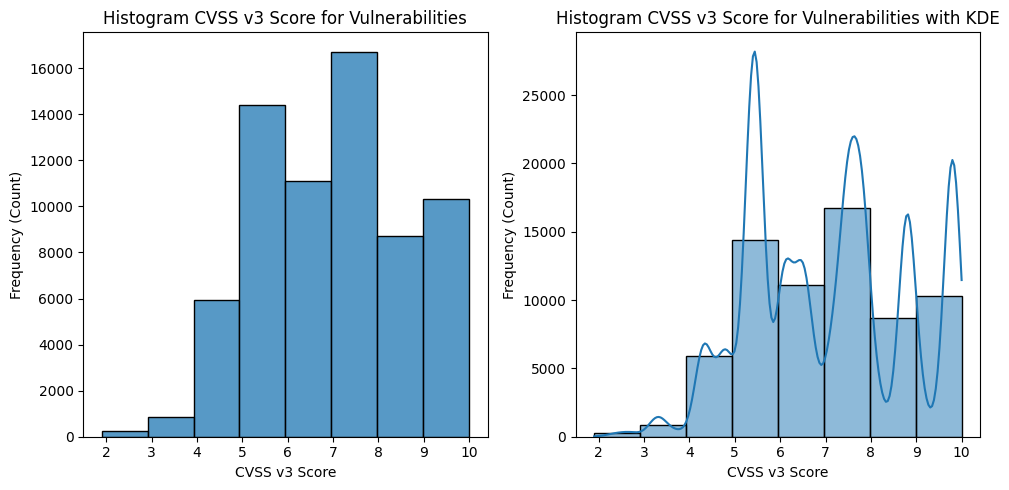

In [ ]:
plt.figure(figsize=(10, 5))

# Histogram

plt.subplot(1, 2, 1) # Select 1st plot
sns.histplot(data=nvd_df, x="CVSS3 Base Score", bins=8, kde=False)
plt.title("Histogram CVSS v3 Score for Vulnerabilities")
plt.xlabel("CVSS v3 Score")
plt.ylabel("Frequency (Count)")

plt.subplot(1, 2, 2) # Select 2nd plot
sns.histplot(data=nvd_df, x="CVSS3 Base Score", bins=8, kde=True)
plt.title("Histogram CVSS v3 Score for Vulnerabilities with KDE")
plt.xlabel("CVSS v3 Score")
plt.ylabel("Frequency (Count)")

plt.tight_layout()
plt.show()

The histogram visualization shows that the typical severity of vulnerabilities is skewed high towards higher values. There is a wide range from 2-10. Higher severity scores are more common than lower serverity scores.

In [ ]:
nvd_df["month"] = nvd_df["Published Date"].dt.to_period("M")

<ipython-input-23-c225dbdd9d3f>:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  nvd_df["month"] = nvd_df["Published Date"].dt.to_period("M")
<ipython-input-23-c225dbdd9d3f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nvd_df["month"] = nvd_df["Published Date"].dt.to_period("M")


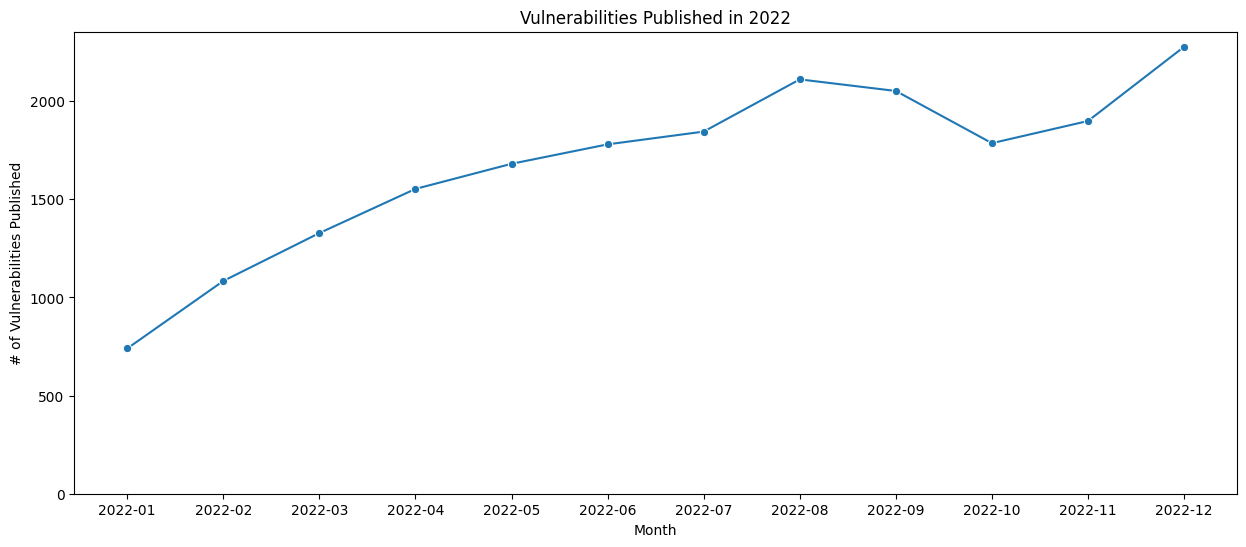

In [ ]:
# SMART Goal 1: Throughout the year 2022, has there been a percentage increase greater than 10% in the
# number of exploited vulnerabilities globally since February 24, 2022?

monthly_count = (nvd_df
                 .groupby('month')
                 ['CVE ID'].count()
                 .reset_index(name="monthly_total")
                 )

monthly_count['month'] = monthly_count['month'].astype(str)

plt.figure(figsize=(15, 6))
sns.lineplot(data=monthly_count.head(12), x='month', y='monthly_total', marker='o')


plt.title('Vulnerabilities Published in 2022')
plt.xlabel('Month')
plt.ylabel('# of Vulnerabilities Published')
plt.ylim(bottom=0)
plt.show()

The first three months of 2022 had a significant increase greater than 10% in the number of vulnerabilities published. This is because of the tension and reignition of the Russo-Ukrainian War when Russia invaded Ukraine on February 24, 2022. After March, the increase began to level off until September, when publications decreased. Since then, the graph of vulnerabilities has increased and decreased for the remaining months of 2022. The peak months in the time series plot were October and December.

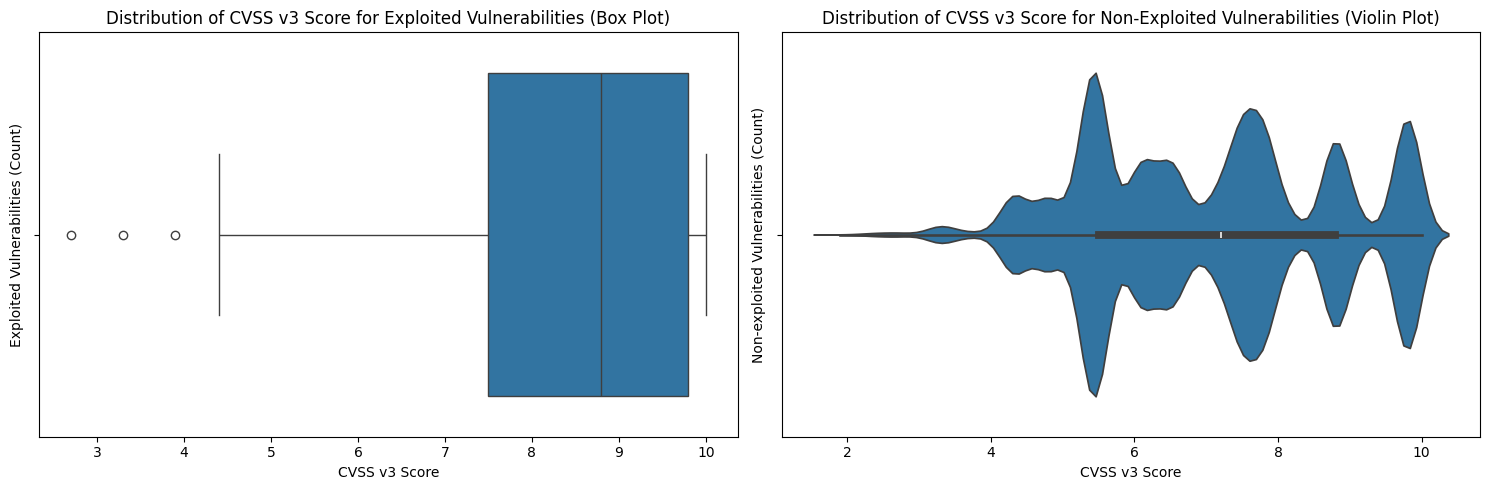

In [ ]:
plt.figure(figsize=(15, 5))

# Box Plot
plt.subplot(1, 2, 1)
sns.boxplot(data=merged_df[merged_df['is_exploited'] == True], x="CVSS3 Base Score")
plt.title("Distribution of CVSS v3 Score for Exploited Vulnerabilities (Box Plot)")
plt.xlabel("CVSS v3 Score")
plt.ylabel("Exploited Vulnerabilities (Count)")

# Violin Plot
plt.subplot(1, 2, 2)
sns.violinplot(data=merged_df[merged_df['is_exploited'] == False], x="CVSS3 Base Score")
plt.title("Distribution of CVSS v3 Score for Non-Exploited Vulnerabilities (Violin Plot)")
plt.xlabel("CVSS v3 Score")
plt.ylabel("Non-exploited Vulnerabilities (Count)")

plt.tight_layout()
plt.show()

The non-exploited vulnerabilities violin plot shows the highest probabilities of severity in the range of 5.5 to 10. The exploited vulnerabilities box plot's interquartile range is between 7.5 and 9.8, which is much tighter and higher in severity than the violin plot.

## Descriptive Statistics

In [ ]:
# SMART Goal 2: What have been the mean Common Vulnerability Scoring System 3 (CVSS3)
# base scores across the NVD, the KEV Catalog, and the CWE from January 1, 2022,
# to December 31, 2024?

merged_df['Published Date'] = pd.to_datetime(merged_df['Published Date'])

start_date = '2022-01-01'
end_date = '2024-12-31'

filtered_df = merged_df[(merged_df['Published Date'] >= start_date) & (merged_df['Published Date'] <= end_date)]

print('The mean CVSS3 Base Score across all three databases from January 1, 2022 to December 31, 2024 is', float(filtered_df['CVSS3 Base Score'].mean()))

The mean CVSS3 Base Score across all three databases from January 1, 2022 to December 31, 2024 is 7.078797290950137


In [ ]:
# All of the discovered CVSS Scores
cvss_stats = {
    'Mean': float(nvd_df['CVSS3 Base Score'].mean()),
    'Median': nvd_df['CVSS3 Base Score'].median(),
    'Standard Deviation': nvd_df['CVSS3 Base Score'].std()
}
cvss_stats

{'Mean': 7.055344953859675,
 'Median': 7.2,
 'Standard Deviation': 1.7194807503100131}

In [ ]:
# The accumulated number of vulnerabilities per year in the NVD DataFrame
vulnerabilities_each_year = nvd_df.groupby(nvd_df['Published Date'].dt.year)['CVE ID'].count()
vulnerabilities_each_year

,CVE ID
Published Date,
2022,20136
2023,28012
2024,39344
2025,6030


In [ ]:
# The total number of vulnerabilites per CWE category
cwe_count = merged_df['CWE ID'].value_counts()
cwe_count

,count
CWE ID,
,32672
NVD-CWE-noinfo,11000
CWE-79,8725
CWE-787,4704
CWE-89,3384
...,...
CWE-643,1
CWE-113,1
CWE-189,1


In [ ]:
# The count of known CWE vulnerabilities
exploited_by_cwe = merged_df[merged_df['is_exploited'] == True].groupby('CWE ID').size().reset_index(name='Exploited Count')
exploited_by_cwe

,CWE ID,Exploited Count
0,,20
1,CWE-116,2
2,CWE-1188,2
3,CWE-119,4
4,CWE-120,3
...,...,...
57,CWE-917,3
58,CWE-918,3
59,CWE-94,17
60,NVD-CWE-Other,26


## Exploratory Inferences

In [ ]:
# SMART Goal 3: What software product has had the highest number of
# security vulnerabilities between 2022 and 2024?

merged_df['Published Date'] = pd.to_datetime(merged_df['Published Date'])

start_date = '2022-01-01'
end_date = '2024-12-31'

filtered_df = merged_df[(merged_df['Published Date'] >= start_date) & (merged_df['Published Date'] <= end_date)]

software_counts = filtered_df['Product'].value_counts()

most_exposed_product = software_counts.idxmax()
most_exposed_count = software_counts.max()

print('The software product with the highest number of vulnerabilities between 2022 and 2024'
'\n was', most_exposed_product, 'with', most_exposed_count, 'vulnerabilities')

The software product with the highest number of vulnerabilities between 2022 and 2024
 was Windows with 50 vulnerabilities


In [ ]:
# Vulnerable software categories and their associated CWE weaknesses
software_cwe = merged_df.groupby(['Product', 'CWE ID']).size().reset_index(name='count')
software_cwe_sorted = software_cwe.sort_values(by='count', ascending=False)
software_cwe_sorted.head(10)

,Product,CWE ID,count
294,Windows,NVD-CWE-noinfo,29
43,Chromium V8,CWE-843,10
290,Windows,CWE-787,7
187,Multiple Products,NVD-CWE-noinfo,5
183,Multiple Products,CWE-787,4
135,Kernel,CWE-416,4
306,Zimbra Collaboration Suite (ZCS),CWE-79,3
305,Zimbra Collaboration Suite (ZCS),CWE-22,3
185,Multiple Products,CWE-843,3
42,Chromium V8,CWE-787,3


In [ ]:
# Evaluating the impact of CVSS score on vulnerability exploitation
cvss_impact = merged_df[['CVSS3 Base Score', 'is_exploited']].groupby('is_exploited').describe().round(2)

In [ ]:
cvss_impact[('CVSS3 Base Score', 'count')] = cvss_impact[('CVSS3 Base Score', 'count')].astype(int)
cvss_impact = cvss_impact.drop([('CVSS3 Base Score', 'std'), ('CVSS3 Base Score', '25%'), ('CVSS3 Base Score', '50%'), ('CVSS3 Base Score', '75%')], axis=1)

In [ ]:
cvss_impact

CVSS3 Base Score                 
                        count  mean  min   max
is_exploited                                  
False                   67876  7.05  1.9  10.0
True                      394  8.40  2.7  10.0

The data describes the cvss3 base scores based on whether the CVE was exploited or not exploited using the KEV catalog. It concludes that the higher the cvss3 score, the higher the probability of it being exploited.

Reasons:
* The exploited CVEs (True) have a higher average cvss3 score (8.40) than the non-exploited CVEs (False) average cvss3 score (7.05).
* According to the data, most CVEs aren't exploited (393 vs. 67,795), but if the CVE was exploited, they will generally have a higher cvss3 score.
* Although both have some max scores of 10, the exploited CVEs generally start at a higher number (2.7) than the non-exploited CVEs (1.9).

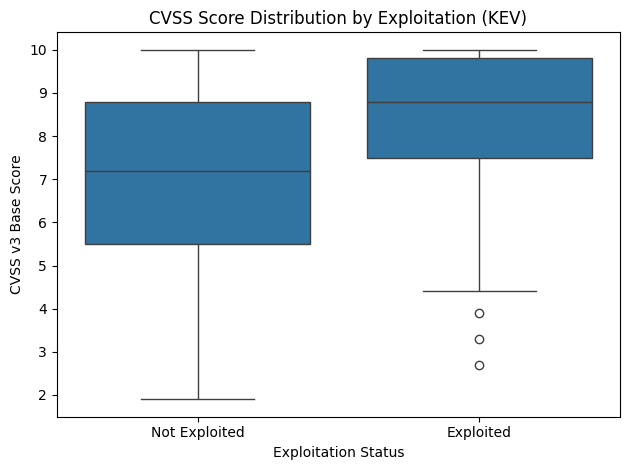

In [ ]:
# Box Plot representation on Vulnerability Exploitation
sns.boxplot(data=merged_df, x='is_exploited', y='CVSS3 Base Score')

plt.xticks([0, 1], ['Not Exploited', 'Exploited'])
plt.xlabel('Exploitation Status')
plt.ylabel('CVSS v3 Base Score')
plt.title('CVSS Score Distribution by Exploitation (KEV)')
plt.tight_layout()
plt.show()


This is a visual representation of a box plot comparing the exploitation of the CVSS scores. The non-exploited scores have a wider interquartile range with most values being approximately between 5.0 and 9.0. In addition, the median is much lower than the exploited scores. The exploited scores have a higher median, but the interquartile range is more narrow, with most values being approximately between 7.0 and 10.0.

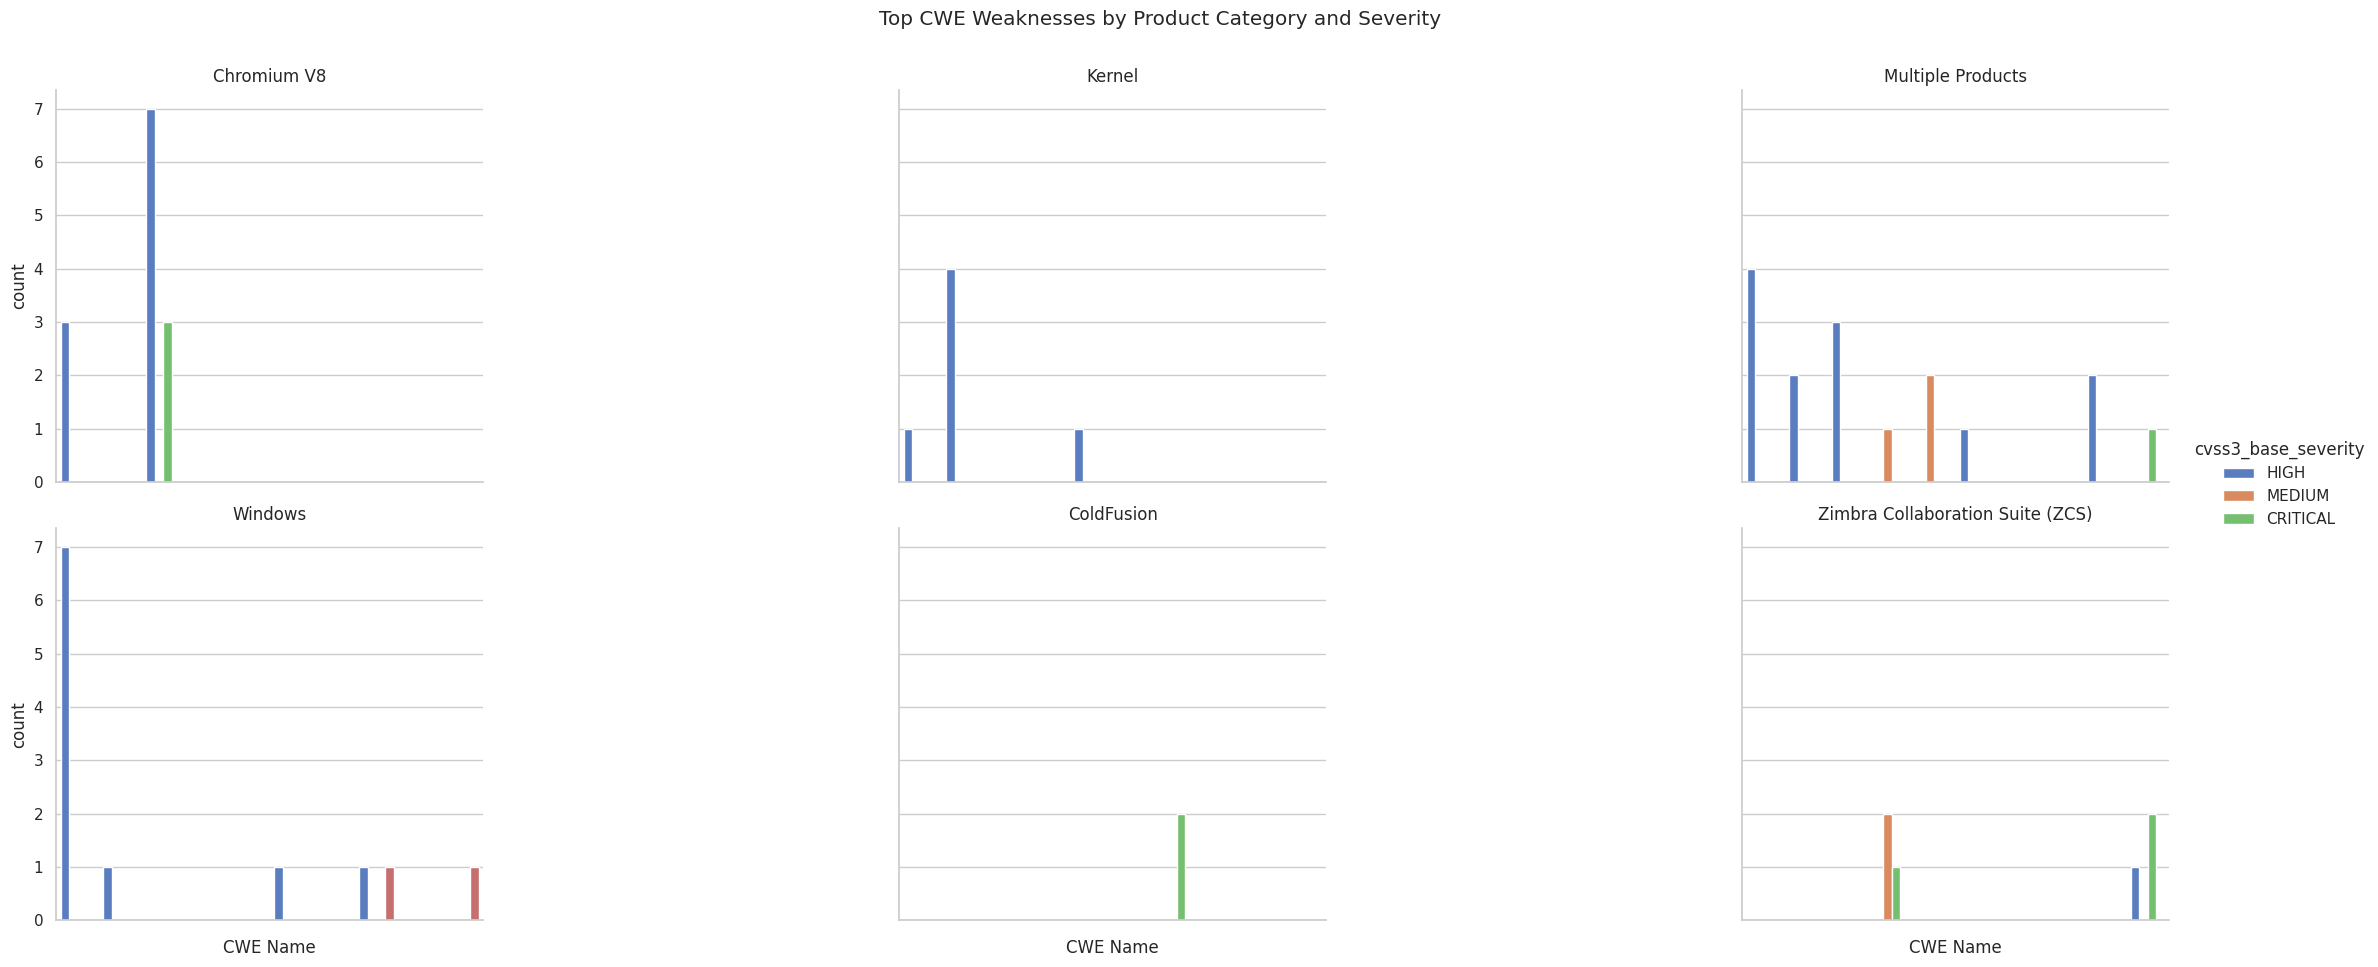

In [ ]:
# Determining potential risk factors based on vulnerability trends and CWE analysis.
grouped = merged_df.groupby(['Product', 'CWE Name']).size().reset_index(name='Count')
top_products = merged_df['Product'].value_counts().nlargest(6).index
filtered = merged_df[merged_df['Product'].isin(top_products)]

# Limit to most common 10 CWE types for each product
top_cwes = filtered['CWE Name'].value_counts().nlargest(10).index
filtered = filtered[filtered['CWE Name'].isin(top_cwes)]

# Plot using catplot
sns.set(style="whitegrid", palette="muted")
g = sns.catplot(
    data=filtered,
    x="CWE Name",
    kind="count",
    hue="cvss3_base_severity",
    col="Product",
    col_wrap=3,
    height=5,
    aspect=1.5
)

g.set_xticklabels(rotation=45, horizontalalignment='right')
g.set_titles("{col_name}")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Top CWE Weaknesses by Product Category and Severity")

plt.show()